# Loading Libraries and Datasets

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import optuna
import re

from category_encoders import OneHotEncoder, MEstimateEncoder, CatBoostEncoder
from sklearn import set_config
from sklearn.inspection import permutation_importance
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import roc_auc_score, roc_curve, make_scorer, f1_score, accuracy_score
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin, clone, ClassifierMixin
from sklearn.preprocessing import FunctionTransformer, StandardScaler, PowerTransformer, MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.kernel_approximation import Nystroem
from sklearn.linear_model import LogisticRegression, RidgeClassifier, Perceptron, SGDClassifier
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.ensemble import HistGradientBoostingClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.gaussian_process import GaussianProcessClassifier
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform
from xgboost import XGBClassifier, XGBRFClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

sns.set_theme(style = 'white', palette = 'viridis')
pal = sns.color_palette('viridis')

pd.set_option('display.max_rows', 100)
set_config(transform_output = 'pandas')
pd.options.mode.chained_assignment = None
#optuna.logging.set_verbosity(optuna.logging.WARNING)

c:\Users\91876\anaconda3\envs\cancer\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
train = pd.read_csv(r'training.csv', index_col = 'patient_id')
test = pd.read_csv(r'test.csv', index_col = 'patient_id')

# Descriptive Statistics

Let's begin by taking a peek at our training dataset first

In [5]:
train.head(10)

,patient_race,payer_type,patient_state,patient_zip3,patient_age,patient_gender,bmi,breast_cancer_diagnosis_code,breast_cancer_diagnosis_desc,metastatic_cancer_diagnosis_code,...,disabled,poverty,limited_english,commute_time,health_uninsured,veteran,Ozone,PM25,N02,DiagPeriodL90D
patient_id,,,,,,,,,,,,,,,,,,,,,
475714,NaN,MEDICAID,CA,924,84,F,NaN,C50919,Malignant neoplasm of unsp site of unspecified...,C7989,...,12.871429,22.542857,10.100000,27.814286,11.200000,3.500000,52.237210,8.650555,18.606528,1
349367,White,COMMERCIAL,CA,928,62,F,28.49,C50411,Malig neoplm of upper-outer quadrant of right ...,C773,...,8.957576,10.109091,8.057576,30.606061,7.018182,4.103030,42.301121,8.487175,20.113179,1
138632,White,COMMERCIAL,TX,760,43,F,38.09,C50112,Malignant neoplasm of central portion of left ...,C773,...,11.253333,9.663333,3.356667,31.394915,15.066667,7.446667,40.108207,7.642753,14.839351,1
617843,White,COMMERCIAL,CA,926,45,F,NaN,C50212,Malig neoplasm of upper-inner quadrant of left...,C773,...,8.845238,8.688095,5.280952,27.561905,4.404762,4.809524,42.070075,7.229393,15.894123,0
817482,NaN,COMMERCIAL,ID,836,55,F,NaN,1749,"Malignant neoplasm of breast (female), unspeci...",C773,...,15.276000,11.224000,1.946000,26.170213,12.088000,13.106000,41.356058,4.110749,11.722197,0
111545,White,MEDICARE ADVANTAGE,NY,141,66,F,NaN,1749,"Malignant neoplasm of breast (female), unspeci...",C7981,...,13.717143,8.888235,0.638235,25.000000,4.797143,7.745714,40.107248,6.181812,13.562528,0
914071,NaN,COMMERCIAL,CA,900,51,F,29.05,C50912,Malignant neoplasm of unspecified site of left...,C779,...,11.901538,20.760000,14.737500,30.709375,10.341538,3.030769,41.186992,11.166898,21.644261,1
479368,White,COMMERCIAL,IL,619,60,F,NaN,C50512,Malig neoplasm of lower-outer quadrant of left...,C773,...,15.260000,10.890000,0.503333,24.275862,8.753333,7.506667,37.646770,7.295977,12.914805,1
994014,White,MEDICARE ADVANTAGE,NaN,973,82,F,NaN,1744,Malignant neoplasm of upper-outer quadrant of ...,C7800,...,19.371875,14.593651,1.620968,26.015254,6.645313,10.955385,36.323573,4.744352,10.439314,0


In [6]:
desc = pd.DataFrame(index = list(train))
desc['type'] = train.dtypes
desc['count'] = train.count()
desc['nunique'] = train.nunique()
desc['%unique'] = desc['nunique'] / len(train) * 100
desc['null'] = train.isnull().sum()
desc['%null'] = desc['null'] / len(train) * 100
#desc['min'] = train.min()
#desc['max'] = train.max()
desc

,type,count,nunique,%unique,null,%null
patient_race,object,6521,5,0.038742,6385,49.473113
payer_type,object,11103,3,0.023245,1803,13.970246
patient_state,object,12855,50,0.387417,51,0.395165
patient_zip3,int64,12906,739,5.726019,0,0.000000
patient_age,int64,12906,67,0.519138,0,0.000000
patient_gender,object,12906,1,0.007748,0,0.000000
bmi,float64,3941,1342,10.398264,8965,69.463815
breast_cancer_diagnosis_code,object,12906,50,0.387417,0,0.000000
breast_cancer_diagnosis_desc,object,12906,50,0.387417,0,0.000000
metastatic_cancer_diagnosis_code,object,12906,43,0.333178,0,0.000000


In [5]:
test.head(10)

,patient_race,payer_type,patient_state,patient_zip3,patient_age,patient_gender,bmi,breast_cancer_diagnosis_code,breast_cancer_diagnosis_desc,metastatic_cancer_diagnosis_code,...,hispanic,disabled,poverty,limited_english,commute_time,health_uninsured,veteran,Ozone,PM25,N02
patient_id,,,,,,,,,,,,,,,,,,,,,
573710,White,MEDICAID,IN,467,54,F,NaN,C50412,Malig neoplasm of upper-outer quadrant of left...,C773,...,3.564516,13.996774,7.985484,0.969355,24.955357,10.838710,8.080645,38.724876,7.947165,11.157161
593679,NaN,COMMERCIAL,FL,337,52,F,NaN,C50912,Malignant neoplasm of unspecified site of left...,C787,...,10.261538,16.020513,13.602564,2.836842,23.952632,10.579487,9.302564,36.918257,7.838973,13.599985
184532,Hispanic,MEDICAID,CA,917,61,F,NaN,C50911,Malignant neoplasm of unsp site of right femal...,C773,...,47.726087,9.895652,10.515217,12.745652,32.530435,7.263043,3.810870,47.310325,9.595719,20.084231
447383,Hispanic,MEDICARE ADVANTAGE,CA,917,64,F,NaN,C50912,Malignant neoplasm of unspecified site of left...,C779,...,47.726087,9.895652,10.515217,12.745652,32.530435,7.263043,3.810870,47.310325,9.595719,20.084231
687972,Black,NaN,CA,900,40,F,23.0,C50412,Malig neoplasm of upper-outer quadrant of left...,C779,...,45.526154,11.901538,20.760000,14.737500,30.709375,10.341538,3.030769,41.186992,11.166898,21.644261
281312,NaN,COMMERCIAL,MI,483,64,F,24.0,1748,Malignant neoplasm of other specified sites of...,C7800,...,4.709804,11.600000,7.454902,2.690196,27.788235,4.488235,5.190196,38.734049,7.935330,21.216445
492714,NaN,COMMERCIAL,TX,761,91,F,NaN,C50912,Malignant neoplasm of unspecified site of left...,C773,...,36.844444,9.816667,13.814286,7.762857,25.350000,19.061111,5.947222,42.056702,7.645426,18.775051
378266,White,MEDICARE ADVANTAGE,IN,473,79,F,NaN,C50212,Malig neoplasm of upper-inner quadrant of left...,C773,...,2.479661,19.032203,12.837931,0.565517,26.073214,8.664407,8.444068,38.950274,7.675727,15.472591
291550,NaN,COMMERCIAL,AZ,852,50,F,NaN,C50919,Malignant neoplasm of unsp site of unspecified...,C773,...,17.659091,10.636364,9.520455,1.863636,24.395455,8.584091,7.495455,47.876706,5.956375,22.014931


In [6]:
desc = pd.DataFrame(index = list(test))
desc['type'] = test.dtypes
desc['count'] = test.count()
desc['nunique'] = test.nunique()
desc['%unique'] = desc['nunique'] / len(test) * 100
desc['null'] = test.isnull().sum()
desc['%null'] = desc['null'] / len(test) * 100
#desc['min'] = test.min()
#desc['max'] = test.max()
desc

,type,count,nunique,%unique,null,%null
patient_race,object,2891,5,0.086326,2901,50.086326
payer_type,object,5032,3,0.051796,760,13.121547
patient_state,object,5771,46,0.794199,21,0.362569
patient_zip3,int64,5792,679,11.723066,0,0.000000
patient_age,int64,5792,67,1.156768,0,0.000000
patient_gender,object,5792,1,0.017265,0,0.000000
bmi,float64,1777,847,14.623619,4015,69.319751
breast_cancer_diagnosis_code,object,5792,46,0.794199,0,0.000000
breast_cancer_diagnosis_desc,object,5792,46,0.794199,0,0.000000
metastatic_cancer_diagnosis_code,object,5792,36,0.621547,0,0.000000


In [7]:
numerical_features = list(test._get_numeric_data())
categorical_features = list(test.select_dtypes('object'))

# Adversarial Validation

In [9]:
def adversarial_validation(dataset_1 = train, dataset_2 = test, target = [], label = 'Train-Test'):

    adv_train = dataset_1.drop(target, axis = 1)
    adv_test = dataset_2.copy()

    adv_train['is_test'] = 0
    adv_test['is_test'] = 1

    adv = pd.concat([adv_train, adv_test], ignore_index = True)

    adv_shuffled = adv.sample(frac = 1)

    adv_X = adv_shuffled.drop('is_test', axis = 1)
    adv_y = adv_shuffled.is_test

    skf = StratifiedKFold(n_splits = 10, random_state = 42, shuffle = True)

    val_scores = []
    predictions = np.zeros(len(adv))

    for fold, (train_idx, val_idx) in enumerate(skf.split(adv_X, adv_y)):
    
        adv_lr = make_pipeline(MEstimateEncoder(cols = categorical_features), XGBClassifier(random_state = 42))
        adv_lr.fit(adv_X.iloc[train_idx], adv_y.iloc[train_idx])
        
        val_preds = adv_lr.predict_proba(adv_X.iloc[val_idx])[:,1]
        predictions[val_idx] = val_preds
        val_score = roc_auc_score(adv_y.iloc[val_idx], val_preds)
        val_scores.append(val_score)
    
    fpr, tpr, _ = roc_curve(adv['is_test'], predictions)
    
    plt.figure(figsize = (10, 10), dpi = 300)
    sns.lineplot(x=[0, 1], y=[0, 1], linestyle="--", label="Indistinguishable Datasets")
    sns.lineplot(x=fpr, y=tpr, label="Adversarial Validation Classifier")
    plt.title(f'{label} Validation = {np.mean(val_scores):.5f}', weight = 'bold', size = 17)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()

In [9]:
#adversarial_validation()

# Corr

In [10]:
def heatmap(dataset, label = None):
    corr = dataset.corr(method = 'spearman')
    plt.figure(figsize = (25, 25), dpi = 300)
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True
    sns.heatmap(corr, mask = mask, cmap = 'viridis', annot = True, annot_kws = {'size' : 5})
    plt.title(f'{label} Dataset Correlation Matrix\n', fontsize = 25, weight = 'bold')
    plt.show()

In [11]:
#heatmap(train[numerical_features])

In [12]:
def distance(data, label = ''):
    #thanks to @sergiosaharovsky for the fix
    corr = data.corr(method = 'spearman')
    dist_linkage = linkage(squareform(1 - abs(corr)), 'complete')
    
    plt.figure(figsize = (10, 8), dpi = 300)
    dendro = dendrogram(dist_linkage, labels=data.columns, leaf_rotation=90)
    plt.title(f'Feature Distance in {label} Dataset', weight = 'bold', size = 20)
    plt.show()

In [13]:
#distance(train[numerical_features])

# Preparation

This is where we start preparing everything if we want to start building machine learning models.

In [14]:
X = train.drop('patient_gender', axis = 1)
y = X.pop('DiagPeriodL90D')

roc_scorer = make_scorer(roc_auc_score, needs_proba = True)

seed = 42
splits = 5
skf = StratifiedKFold(n_splits = splits, random_state = seed, shuffle = True)
tf.keras.utils.set_random_seed(seed)

# Feature Engineering

In [15]:
class FeatureDropper(BaseEstimator, TransformerMixin):
    
    def __init__(self, cols):
        self.cols = cols
        
    def fit(self, x, y):
        return self
    
    def transform(self, x):
        return x.drop(self.cols, axis = 1)

In [16]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    
    def __init__(self, cols):
        self.cols = cols
        
    def fit(self, x, y):
        return self
    
    def transform(self, x):
        return x[self.cols]

In [17]:
class RaceWrapper(BaseEstimator, ClassifierMixin):
    
    def __init__(self, estimator):
        self.estimator = estimator
        
    def fit(self, x, y):
        self.models = {}
        self.models['null'] = clone(self.estimator).fit(x[x.patient_race.isna()], y[x.patient_race.isna()])
        self.models['no_null'] = clone(self.estimator).fit(x[~x.patient_race.isna()], y[~x.patient_race.isna()])
        return self
    
    def predict_proba(self, x):
        prediction = np.zeros((len(x), 2))
        prediction[x.patient_race.isna()] = self.models['null'].predict_proba(x[x.patient_race.isna()])
        prediction[~x.patient_race.isna()] = self.models['no_null'].predict_proba(x[~x.patient_race.isna()])
        return prediction

In [18]:
class BMIWrapper(BaseEstimator, ClassifierMixin):
    
    def __init__(self, estimator):
        self.estimator = estimator
        
    def fit(self, x, y):
        self.models = {}
        self.models['null'] = clone(self.estimator).fit(x[x.bmi.isna()], y[x.bmi.isna()])
        self.models['no_null'] = clone(self.estimator).fit(x[~x.bmi.isna()], y[~x.bmi.isna()])
        return self
    
    def predict_proba(self, x):
        prediction = np.zeros((len(x), 2))
        prediction[x.bmi.isna()] = self.models['null'].predict_proba(x[x.bmi.isna()])
        prediction[~x.bmi.isna()] = self.models['no_null'].predict_proba(x[~x.bmi.isna()])
        return prediction

In [19]:
class ICDWrapper(BaseEstimator, ClassifierMixin):
    
    def __init__(self, estimator):
        self.estimator = estimator
        
    def fit(self, x, y):
        self.models = {}
        condition = x.breast_cancer_diagnosis_code.astype(str).str[0] == 'C'
        self.models['ICD10'] = clone(self.estimator).fit(x[condition], y[condition])
        self.models['ICD9'] = clone(self.estimator).fit(x[~condition], y[~condition])
        return self
    
    def predict_proba(self, x):
        prediction = np.zeros((len(x), 2))
        condition = x.breast_cancer_diagnosis_code.astype(str).str[0] == 'C'
        prediction[condition] = self.models['ICD10'].predict_proba(x[condition])
        prediction[~condition] = self.models['ICD9'].predict_proba(x[~condition])
        return prediction

In [20]:
class RaceImputer(BaseEstimator, ClassifierMixin):
    
    def __init__(self, estimator):
        self.estimator = estimator
        
    def fit(self, x):
        
        train_data = x[~x.patient_race.isna()]
        target = x.pop('patient_race')
        
        self.le = LabelEncoder().fit(target)
        target = self.le.transform(target)
        
        self.estimator.fit(train_data, target)
        return self
    
    def transform(self, x):
        
        rain_data = x[x.patient_race.isna()]
        target = x.pop('patient_race')
        target = self.le.transform(target)
        
        prediction = self.le.transform(prediction)

In [21]:
class Vectorizer(BaseEstimator, TransformerMixin):
    
    def __init__(self, max_features = 1000, cols = ['breast_cancer_diagnosis_desc'], n_components = 3):
        self.max_features = max_features
        self.cols = cols
        self.n_components = n_components
        
    def fit(self, x, y):
        self.vectorizer_dict = {}
        self.decomposer_dict = {}
        
        for col in self.cols:
            self.vectorizer_dict[col] = TfidfVectorizer(max_features = self.max_features).fit(x[col].astype(str), y)
            self.decomposer_dict[col] = TruncatedSVD(random_state = seed, n_components = self.n_components).fit(
                self.vectorizer_dict[col].transform(x[col].astype(str)), y
            )
        
        return self
    
    def transform(self, x):
        vectorized = {}
        
        for col in self.cols:
            vectorized[col] = self.vectorizer_dict[col].transform(x[col].astype(str))
            vectorized[col] = self.decomposer_dict[col].transform(vectorized[col])
        
        vectorized_df = pd.concat([pd.DataFrame(vectorized[col]).rename({
            f'truncatedsvd{i}' : f'{col}SVD{i}' for i in range(self.n_components)
        }, axis = 1) for col in self.cols], axis = 1)
        
        return pd.concat([x.reset_index(drop = True), vectorized_df], axis = 1)

In [22]:
def cat_imputer(x):
    x_copy = x.copy()
    x_copy[list(x_copy.select_dtypes('object'))] = x_copy[list(x_copy.select_dtypes('object'))].fillna('Null').astype(str)
    return x_copy

CatImputer = FunctionTransformer(cat_imputer)

In [23]:
def all_cat(x):
    x_copy = x.copy()
    x_copy['all_cat'] = ''
    for col in list(x.select_dtypes('object')) + ['patient_zip3'] if 'patient_zip3' in list(x) else []:
        x_copy['all_cat'] += x_copy[col].astype(str)
    return x_copy

AllCat = FunctionTransformer(all_cat)

In [24]:
def null_indicator(x):
    x_copy = x.copy()
    x_copy['bmi_null'] = x_copy.bmi.isna().astype('object')
    x_copy['atmos_null'] = x_copy.Ozone.isna().astype('object')
    x_copy['size_null'] = x_copy.family_size.isna().astype('object')
    return x_copy

NullIndicator = FunctionTransformer(null_indicator)

In [25]:
def float_rounder(x):
    x_copy = x.copy()
    x_copy.loc[:, x.select_dtypes('float').columns] = (x_copy.loc[:, x.select_dtypes('float').columns] * 1e6).fillna(0)
    x_copy = x_copy.astype({col : np.uint64 for col in x.select_dtypes('float').columns})
    return x_copy

FloatRounder = FunctionTransformer(float_rounder)

In [26]:
def desc_cleaner(x):
    x_copy = x.copy()
    
    rep = {
        #'malig ' : 'malignant ',
        'malig ' : '',
        'malignant ' : '',
        #'neoplm' : 'neoplasm',
        'neoplm ' : '',
        'neoplasm ' : '',
        'unsp ' : 'unspecified ',
        'ovrlp' : 'overlapping',
        'sites' : 'site',
        'site,' : 'site',
        'breast,' : 'breast',
        'areola,' : 'areola',
        '(female),' : 'female',
        #' of ' : ' ',
        'of ' : '',
        ' and ' : ' ',
        '-' : ' '
    }
    rep = dict((re.escape(k), v) for k, v in rep.items())
    pattern = re.compile("|".join(rep.keys()))

    x_copy['breast_cancer_diagnosis_desc'] = x_copy.breast_cancer_diagnosis_desc.astype('str').apply(
        lambda x: pattern.sub(lambda m: rep[re.escape(m.group(0))], x.lower())
    )
    
    return x_copy

DescCleaner = FunctionTransformer(desc_cleaner)

In [27]:
def desc_indicator(x):
    x_copy = x.copy()
    x_copy['breast_cancer_diagnosis_desc'] = x_copy.breast_cancer_diagnosis_desc.astype(str).apply(lambda x: 'upper' in x).astype(str) +\
                        x_copy.breast_cancer_diagnosis_desc.astype(str).apply(lambda x: 'lower' in x).astype(str) +\
                        x_copy.breast_cancer_diagnosis_desc.astype(str).apply(lambda x: 'inner' in x).astype(str) +\
                        x_copy.breast_cancer_diagnosis_desc.astype(str).apply(lambda x: 'outer' in x).astype(str) +\
                        x_copy.breast_cancer_diagnosis_desc.astype(str).apply(lambda x: 'axillary' in x).astype(str) +\
                        x_copy.breast_cancer_diagnosis_desc.astype(str).apply(lambda x: 'breast' in x).astype(str) +\
                        x_copy.breast_cancer_diagnosis_desc.astype(str).apply(lambda x: 'secondary' in x).astype(str) +\
                        x_copy.breast_cancer_diagnosis_desc.astype(str).apply(lambda x: 'other' in x).astype(str) +\
                        x_copy.breast_cancer_diagnosis_desc.astype(str).apply(lambda x: 'areola' in x).astype(str) +\
                        x_copy.breast_cancer_diagnosis_desc.astype(str).apply(lambda x: 'overlapping' in x).astype(str) +\
                        x_copy.breast_cancer_diagnosis_desc.astype(str).apply(lambda x: 'central' in x).astype(str) +\
                        x_copy.breast_cancer_diagnosis_desc.astype(str).apply(lambda x: 'unspecified site' in x).astype(str) +\
                        x_copy.breast_cancer_diagnosis_desc.astype(str).apply(lambda x: 'male' in x).astype(str) +\
                        x_copy.breast_cancer_diagnosis_desc.astype(str).apply(lambda x: 'female' in x).astype(str) +\
                        x_copy.breast_cancer_diagnosis_desc.astype(str).apply(lambda x: 'left' in x).astype(str) +\
                        x_copy.breast_cancer_diagnosis_desc.astype(str).apply(lambda x: 'right' in x).astype(str) +\
                        x_copy.breast_cancer_diagnosis_desc.astype(str).apply(lambda x: 'unspecified male' in x or 'unspecified female' in x).astype(str)
    return x_copy

DescIndicator = FunctionTransformer(desc_indicator)

In [28]:
def desc_indicator_2(x):
    x_copy = x.copy()
    x_copy['upper'] = x_copy.breast_cancer_diagnosis_desc.astype(str).apply(lambda x: 'upper' in x)
    x_copy['lower'] = x_copy.breast_cancer_diagnosis_desc.astype(str).apply(lambda x: 'lower' in x)
    x_copy['inner'] = x_copy.breast_cancer_diagnosis_desc.astype(str).apply(lambda x: 'inner' in x)
    x_copy['outer'] = x_copy.breast_cancer_diagnosis_desc.astype(str).apply(lambda x: 'outer' in x)
    x_copy['axillary'] = x_copy.breast_cancer_diagnosis_desc.astype(str).apply(lambda x: 'axillary' in x)
    x_copy['breast'] = x_copy.breast_cancer_diagnosis_desc.astype(str).apply(lambda x: 'breast' in x)
    x_copy['secondary'] = x_copy.breast_cancer_diagnosis_desc.astype(str).apply(lambda x: 'secondary' in x)
    x_copy['other'] = x_copy.breast_cancer_diagnosis_desc.astype(str).apply(lambda x: 'other' in x)
    x_copy['areola'] = x_copy.breast_cancer_diagnosis_desc.astype(str).apply(lambda x: 'areola' in x)
    x_copy['overlapping'] = x_copy.breast_cancer_diagnosis_desc.astype(str).apply(lambda x: 'overlapping' in x)
    x_copy['central'] = x_copy.breast_cancer_diagnosis_desc.astype(str).apply(lambda x: 'central' in x)
    x_copy['unspecified'] = x_copy.breast_cancer_diagnosis_desc.astype(str).apply(lambda x: 'unspecified site' in x)
    x_copy['breast_male'] = x_copy.breast_cancer_diagnosis_desc.astype(str).apply(lambda x: 'male' in x)
    x_copy['breast_female'] = x_copy.breast_cancer_diagnosis_desc.astype(str).apply(lambda x: 'female' in x)
    x_copy['left'] = x_copy.breast_cancer_diagnosis_desc.astype(str).apply(lambda x: 'left' in x)
    x_copy['right'] = x_copy.breast_cancer_diagnosis_desc.astype(str).apply(lambda x: 'right' in x)
    x_copy['unspecified_lr'] = x_copy.breast_cancer_diagnosis_desc.astype(str).apply(lambda x: 'unspecified male' in x or 'unspecified female' in x)
    return x_copy.drop('breast_cancer_diagnosis_desc', axis = 1)

DescIndicator2 = FunctionTransformer(desc_indicator_2)

In [29]:
def zip_splitter(x):
    x_copy = x.copy()
    x_copy['zip1'] = x_copy.patient_zip3.astype(str).str[0]
    x_copy['zip2'] = x_copy.patient_zip3.astype(str).str[1:]
    return x_copy

ZIPSplitter = FunctionTransformer(zip_splitter)

In [30]:
def icd_switcher(x):
    x_copy = x.copy()
    x_copy['ICD10'] = (x_copy.breast_cancer_diagnosis_code.astype(str).str[0] == 'C').astype('object')
    return x_copy

ICDSwitcher = FunctionTransformer(icd_switcher)

In [31]:
def metastatic_grouper(x):
    x_copy = x.copy()
    x_copy['metastatic_group'] = x.metastatic_cancer_diagnosis_code.astype(str).str[:3]
    return x_copy

MetastaticGrouper = FunctionTransformer(metastatic_grouper)

In [32]:
def region_binner(x):
    x_copy = x.copy()
    x_copy['regional_age_bin'] = np.argmax(x[['age_under_10', 'age_10_to_19',
       'age_20s', 'age_30s', 'age_40s', 'age_50s', 'age_60s', 'age_70s',
       'age_over_80']], axis = 1)
    x_copy['regional_income_bin'] = np.argmax(x[['income_household_under_5',
       'income_household_5_to_10', 'income_household_10_to_15',
       'income_household_15_to_20', 'income_household_20_to_25',
       'income_household_25_to_35', 'income_household_35_to_50',
       'income_household_50_to_75', 'income_household_75_to_100',
       'income_household_100_to_150', 'income_household_150_over']], axis = 1)
    x_copy['regional_edu_bin'] = np.argmax(x[['education_less_highschool', 'education_highschool',
       'education_some_college', 'education_bachelors', 'education_graduate',
       'education_college_or_above', 'education_stem_degree']], axis = 1)
    return x_copy#.astype({'regional_age_bin' : 'object', 'regional_income_bin' : 'object', 'regional_edu_bin' : 'object'})

RegionBinner = FunctionTransformer(region_binner)

In [33]:
def binner(x):
    x_copy = x.copy()
    x_copy['binned_age'] = (x_copy['patient_age'] / 2).astype(np.uint8)
    return x_copy#.astype({'binned_age' : 'object'})

Binner = FunctionTransformer(binner)

In [34]:
Preprocessor = make_pipeline(DescCleaner, DescIndicator, ICDSwitcher, Binner, NullIndicator)

In [35]:
def svd_rounder(x):
    
    x_copy = x.copy()
    for col in [column for column in list(x) if 'SVD' in column]:
        x_copy[col] = (x_copy[col] * 1e18).astype(np.int64)
        
    return x_copy

SVDRounder = FunctionTransformer(svd_rounder)

In [36]:
ToNumpy = FunctionTransformer(lambda x: x.to_numpy())

In [37]:
Sorter = FunctionTransformer(lambda x: x.sort_values(by = 'breast_cancer_diagnosis_code'))

# Model Cross Validation

In [38]:
def cross_val_score(estimator, cv = skf, label = '', show_importance = False, pseudolabelling = False):
    
    X = train.copy()
    y = X.pop('DiagPeriodL90D')
    
    #initiate prediction arrays and score lists
    val_predictions = np.zeros((len(X)))
    train_scores, val_scores= [], []
    
    feature_importances_table = pd.DataFrame({'value' : 0}, index = list(X.columns))
    
    test_predictions = np.zeros((len(test)))
    
    #training model, predicting prognosis probability, and evaluating metrics
    for fold, (train_idx, val_idx) in enumerate(cv.split(X, y)):
        
        model = clone(estimator)
        
        #define train set
        X_train = X.iloc[train_idx].reset_index(drop = True)
        y_train = y.iloc[train_idx].reset_index(drop = True)
        
        #define validation set
        X_val = X.iloc[val_idx].reset_index(drop = True)
        y_val = y.iloc[val_idx].reset_index(drop = True)
        
        #train model
        model.fit(X_train, y_train)
        
        if pseudolabelling:
            pseudolabel = model.predict_proba(X_val).argmax(axis = 1)
            
            pseudo_X = pd.concat([X_train, X_val]).reset_index(drop = True)
            pseudo_y = pd.concat([y_train, pd.Series(pseudolabel)]).reset_index(drop = True)
            
            model.fit(pseudo_X, pseudo_y)
        
        #make predictions
        train_preds = model.predict_proba(X_train)[:, 1]
        val_preds = model.predict_proba(X_val)[:, 1]
                  
        val_predictions[val_idx] += val_preds
        test_predictions += model.predict_proba(test)[:, 1] / cv.get_n_splits()
        if show_importance:
            feature_importances_table['value'] += permutation_importance(model, X_val, y_val, random_state = seed, scoring = make_scorer(roc_auc_score, needs_proba = True), n_repeats = 5).importances_mean / cv.get_n_splits()
        
        #evaluate model for a fold
        train_score = roc_auc_score(y_train, train_preds)
        val_score = roc_auc_score(y_val, val_preds)
        
        #append model score for a fold to list
        train_scores.append(train_score)
        val_scores.append(val_score)
       
    if show_importance:
        plt.figure(figsize = (20, 30))
        plt.title(f'Features with Biggest Importance of {np.mean(val_scores):.5f} ± {np.std(val_scores):.5f} Model', size = 25, weight = 'bold')
        sns.barplot(feature_importances_table.sort_values('value', ascending = False).T, orient = 'h', palette = 'viridis')
        plt.show()
    else:
        print(f'Val Score: {np.mean(val_scores):.5f} ± {np.std(val_scores):.5f} | Train Score: {np.mean(train_scores):.5f} ± {np.std(train_scores):.5f} | {label}')
    
    return val_scores, val_predictions, test_predictions

In [39]:
score_list, oof_list, predict_list = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()

# Feature Selector

In [40]:
"""
Sequential feature selection
"""
from numbers import Integral, Real

import numpy as np

from sklearn.base import BaseEstimator, MetaEstimatorMixin, clone, is_classifier
from sklearn.metrics import get_scorer_names
from sklearn.model_selection import check_cv
from sklearn.utils._param_validation import HasMethods, Interval, StrOptions
from sklearn.utils._tags import _safe_tags
from sklearn.utils.validation import check_is_fitted
from sklearn.feature_selection._base import SelectorMixin


class SequentialFeatureSelector(SelectorMixin, MetaEstimatorMixin, BaseEstimator):
    """Transformer that performs Sequential Feature Selection.

    This Sequential Feature Selector adds (forward selection) or
    removes (backward selection) features to form a feature subset in a
    greedy fashion. At each stage, this estimator chooses the best feature to
    add or remove based on the cross-validation score of an estimator. In
    the case of unsupervised learning, this Sequential Feature Selector
    looks only at the features (X), not the desired outputs (y).

    Read more in the :ref:`User Guide <sequential_feature_selection>`.

    .. versionadded:: 0.24

    Parameters
    ----------
    estimator : estimator instance
        An unfitted estimator.

    n_features_to_select : "auto", int or float, default="auto"
        If `"auto"`, the behaviour depends on the `tol` parameter:

        - if `tol` is not `None`, then features are selected while the score
          change does not exceed `tol`.
        - otherwise, half of the features are selected.

        If integer, the parameter is the absolute number of features to select.
        If float between 0 and 1, it is the fraction of features to select.

        .. versionadded:: 1.1
           The option `"auto"` was added in version 1.1.

        .. versionchanged:: 1.3
           The default changed from `"warn"` to `"auto"` in 1.3.

    tol : float, default=None
        If the score is not incremented by at least `tol` between two
        consecutive feature additions or removals, stop adding or removing.

        `tol` can be negative when removing features using `direction="backward"`.
        It can be useful to reduce the number of features at the cost of a small
        decrease in the score.

        `tol` is enabled only when `n_features_to_select` is `"auto"`.

        .. versionadded:: 1.1

    direction : {'forward', 'backward'}, default='forward'
        Whether to perform forward selection or backward selection.

    scoring : str or callable, default=None
        A single str (see :ref:`scoring_parameter`) or a callable
        (see :ref:`scoring`) to evaluate the predictions on the test set.

        NOTE that when using a custom scorer, it should return a single
        value.

        If None, the estimator's score method is used.

    cv : int, cross-validation generator or an iterable, default=None
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

        - None, to use the default 5-fold cross validation,
        - integer, to specify the number of folds in a `(Stratified)KFold`,
        - :term:`CV splitter`,
        - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if the estimator is a classifier and ``y`` is
        either binary or multiclass,
        :class:`~sklearn.model_selection.StratifiedKFold` is used. In all other
        cases, :class:`~sklearn.model_selection.KFold` is used. These splitters
        are instantiated with `shuffle=False` so the splits will be the same
        across calls.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validation strategies that can be used here.

    n_jobs : int, default=None
        Number of jobs to run in parallel. When evaluating a new feature to
        add or remove, the cross-validation procedure is parallel over the
        folds.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    Attributes
    ----------
    n_features_in_ : int
        Number of features seen during :term:`fit`. Only defined if the
        underlying estimator exposes such an attribute when fit.

        .. versionadded:: 0.24

    feature_names_in_ : ndarray of shape (`n_features_in_`,)
        Names of features seen during :term:`fit`. Defined only when `X`
        has feature names that are all strings.

        .. versionadded:: 1.0

    n_features_to_select_ : int
        The number of features that were selected.

    support_ : ndarray of shape (n_features,), dtype=bool
        The mask of selected features.

    See Also
    --------
    GenericUnivariateSelect : Univariate feature selector with configurable
        strategy.
    RFE : Recursive feature elimination based on importance weights.
    RFECV : Recursive feature elimination based on importance weights, with
        automatic selection of the number of features.
    SelectFromModel : Feature selection based on thresholds of importance
        weights.

    Examples
    --------
    >>> from sklearn.feature_selection import SequentialFeatureSelector
    >>> from sklearn.neighbors import KNeighborsClassifier
    >>> from sklearn.datasets import load_iris
    >>> X, y = load_iris(return_X_y=True)
    >>> knn = KNeighborsClassifier(n_neighbors=3)
    >>> sfs = SequentialFeatureSelector(knn, n_features_to_select=3)
    >>> sfs.fit(X, y)
    SequentialFeatureSelector(estimator=KNeighborsClassifier(n_neighbors=3),
                              n_features_to_select=3)
    >>> sfs.get_support()
    array([ True, False,  True,  True])
    >>> sfs.transform(X).shape
    (150, 3)
    """

    _parameter_constraints: dict = {
        "estimator": [HasMethods(["fit"])],
        "n_features_to_select": [
            StrOptions({"auto"}),
            Interval(Real, 0, 1, closed="right"),
            Interval(Integral, 0, None, closed="neither"),
        ],
        "tol": [None, Interval(Real, None, None, closed="neither")],
        "direction": [StrOptions({"forward", "backward"})],
        "scoring": [None, StrOptions(set(get_scorer_names())), callable],
        "cv": ["cv_object"],
        "n_jobs": [None, Integral],
    }

    def __init__(
        self,
        estimator,
        *,
        n_features_to_select="auto",
        tol=None,
        direction="forward",
        scoring=None,
        cv=5,
        n_jobs=None,
    ):
        self.estimator = estimator
        self.n_features_to_select = n_features_to_select
        self.tol = tol
        self.direction = direction
        self.scoring = scoring
        self.cv = cv
        self.n_jobs = n_jobs

    #@_fit_context(
        # SequentialFeatureSelector.estimator is not validated yet
    #    prefer_skip_nested_validation=False
    #)
    def fit(self, X, y=None):
        """Learn the features to select from X.

        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Training vectors, where `n_samples` is the number of samples and
            `n_features` is the number of predictors.

        y : array-like of shape (n_samples,), default=None
            Target values. This parameter may be ignored for
            unsupervised learning.

        Returns
        -------
        self : object
            Returns the instance itself.
        """
        tags = self._get_tags()
        #X = self._validate_data(
        #    X,
        #    accept_sparse="csc",
        #    ensure_min_features=2,
        #    force_all_finite=not tags.get("allow_nan", True),
        #)
        n_features = X.shape[1]

        if self.n_features_to_select == "auto":
            if self.tol is not None:
                # With auto feature selection, `n_features_to_select_` will be updated
                # to `support_.sum()` after features are selected.
                self.n_features_to_select_ = n_features - 1
            else:
                self.n_features_to_select_ = n_features // 2
        elif isinstance(self.n_features_to_select, Integral):
            if self.n_features_to_select >= n_features:
                raise ValueError("n_features_to_select must be < n_features.")
            self.n_features_to_select_ = self.n_features_to_select
        elif isinstance(self.n_features_to_select, Real):
            self.n_features_to_select_ = int(n_features * self.n_features_to_select)

        if self.tol is not None and self.tol < 0 and self.direction == "forward":
            raise ValueError("tol must be positive when doing forward selection")

        cv = check_cv(self.cv, y, classifier=is_classifier(self.estimator))

        cloned_estimator = clone(self.estimator)

        # the current mask corresponds to the set of features:
        # - that we have already *selected* if we do forward selection
        # - that we have already *excluded* if we do backward selection
        current_mask = np.zeros(shape=n_features, dtype=bool)
        n_iterations = (
            self.n_features_to_select_
            if self.n_features_to_select == "auto" or self.direction == "forward"
            else n_features - self.n_features_to_select_
        )

        old_score = -np.inf
        is_auto_select = self.tol is not None and self.n_features_to_select == "auto"
        for _ in range(n_iterations):
            new_feature_idx, new_score = self._get_best_new_feature_score(
                cloned_estimator, X, y, cv, current_mask
            )
            if is_auto_select and ((new_score - old_score) < self.tol):
                break

            old_score = new_score
            current_mask[new_feature_idx] = True

        if self.direction == "backward":
            current_mask = ~current_mask

        self.support_ = current_mask
        self.n_features_to_select_ = self.support_.sum()

        return self

    def _get_best_new_feature_score(self, estimator, X, y, cv, current_mask):
        # Return the best new feature and its score to add to the current_mask,
        # i.e. return the best new feature and its score to add (resp. remove)
        # when doing forward selection (resp. backward selection).
        # Feature will be added if the current score and past score are greater
        # than tol when n_feature is auto,
        candidate_feature_indices = np.flatnonzero(~current_mask)
        scores = {}
        for feature_idx in candidate_feature_indices:
            candidate_mask = current_mask.copy()
            candidate_mask[feature_idx] = True
            if self.direction == "backward":
                candidate_mask = ~candidate_mask
            X_new = X.iloc[:, candidate_mask]
            scores[feature_idx] = cross_val_score_sfs(
                estimator,
                X_new,
                y,
                cv=cv,
                scoring=self.scoring,
                n_jobs=self.n_jobs,
            ).mean()
        new_feature_idx = max(scores, key=lambda feature_idx: scores[feature_idx])
        return new_feature_idx, scores[new_feature_idx]

    def _get_support_mask(self):
        check_is_fitted(self)
        return self.support_

    def _more_tags(self):
        return {
            "allow_nan": _safe_tags(self.estimator, key="allow_nan"),
        }

In [41]:
def cross_val_score_sfs(estimator, X, y, cv, scoring, n_jobs):
    
    categorical_features = list(X.select_dtypes('object'))
    #if 'patient_zip3' in list(X):
    #    categorical_features += ['patient_zip3']
    
    scores = np.zeros((cv.get_n_splits()))
    
    if list(X) == ['patient_gender']:
        return np.array([.5])
    
    for fold, (train_idx, val_idx) in enumerate(cv.split(X, y)):
        
        X_train = X.iloc[train_idx].reset_index(drop = True)
        y_train = y.iloc[train_idx].reset_index(drop = True)
        
        X_val = X.iloc[val_idx].reset_index(drop = True)
        y_val = y.iloc[val_idx].reset_index(drop = True)
        
        enc = MEstimateEncoder(cols = categorical_features).fit(X_train, y_train)
        X_train = enc.transform(X_train)
        X_val = enc.transform(X_val)
        
        if 'patient_zip3' in X.columns:
            cat_enc = CatBoostEncoder(cols = ['patient_zip3']).fit(X_train, y_train)
            X_train = cat_enc.transform(X_train)
            X_val = cat_enc.transform(X_val)
        
        model = clone(estimator).fit(X_train, y_train)
        
        #model = make_pipeline(
        #    CatImputer,
        #    CatBoostClassifier(random_state = seed, verbose = 0, cat_features = categorical_features)
        #).fit(X_train, y_train)
        
        scores[fold] = scoring(model, X_val, y_val)
        
    print(f'{scores.mean():.5f}: {list(X)}')
        
    return scores

In [42]:
'''SequentialFeatureSelector(
    make_pipeline(SimpleImputer(), StandardScaler(), ScaledRidgeClassifier()),
    scoring = roc_scorer,
    tol = -1e-4,
    cv = skf,
    direction = 'backward'
).fit(
    (Preprocessor.transform(X)),
    y
).transform(
    (Preprocessor.transform(X)).fillna(0)
)'''

"SequentialFeatureSelector(\n    make_pipeline(SimpleImputer(), StandardScaler(), ScaledRidgeClassifier()),\n    scoring = roc_scorer,\n    tol = -1e-4,\n    cv = skf,\n    direction = 'backward'\n).fit(\n    (Preprocessor.transform(X)),\n    y\n).transform(\n    (Preprocessor.transform(X)).fillna(0)\n)"

# Neural Network

In [43]:
class TensorFlower(BaseEstimator, ClassifierMixin):
    
    def fit(self, x, y):
        
        tf.keras.utils.set_random_seed(seed)
        tf.config.experimental.enable_op_determinism()
        
        inputs = tf.keras.Input((x.shape[1],))
        x0 = tf.keras.layers.BatchNormalization()(inputs)
        
        x1 = tf.keras.layers.Dense(64)(x0)
        x1 = tf.keras.layers.BatchNormalization()(x1)
        x1 = tf.keras.layers.LeakyReLU()(x1)
        
        x2 = tf.keras.layers.Dense(16)(x1)
        x2 = tf.keras.layers.BatchNormalization()(x2)
        x2 = tf.keras.layers.LeakyReLU()(x2)
        
        x3 = tf.keras.layers.Dense(4)(x2)
        x3 = tf.keras.layers.BatchNormalization()(x3)
        x3 = tf.keras.layers.LeakyReLU()(x3)
        
        x4 = tf.keras.layers.Dense(1)(x3)
        x4 = tf.keras.layers.BatchNormalization()(x4)
        outputs = tf.keras.activations.sigmoid(x4)
        
        self.model = tf.keras.Model(inputs, outputs)
        self.model.compile(loss = 'binary_crossentropy', optimizer = tf.keras.optimizers.AdamW(1e-4))
        
        self.model.fit(x, y, epochs = 50, verbose = 0)
        self.classes_ = np.unique(y)
        
        return self
    
    def predict_proba(self, x):
        
        probabilities = np.zeros((len(x), 2))
        probabilities[:, 1] = self.model.predict(x, verbose = 0)[:, 0]
        probabilities[:, 0] = 1 - probabilities[:, 1]
        return probabilities
    
    def predict(self, x):
        
        return np.argmax(self.predict_proba(x), axis = 1)
        

In [44]:
TensorFlowey = make_pipeline(
    Preprocessor,
    MEstimateEncoder(cols = ['patient_gender', 'payer_type', 'breast_cancer_diagnosis_code', 'breast_cancer_diagnosis_desc', 'metastatic_cancer_diagnosis_code', 'metastatic_first_novel_treatment', 'metastatic_first_novel_treatment_type', 'bmi_null', 'atmos_null', 'size_null']),
    MEstimateEncoder(cols = ['patient_race', 'patient_state', 'Region', 'Division'], handle_missing = 'return_nan'),
    FeatureSelector(['payer_type', 'patient_age', 'metastatic_cancer_diagnosis_code', 'age_40s', 'age_50s', 'age_over_80', 'family_size', 'income_household_75_to_100', 'home_value', 'education_less_highschool', 'education_some_college', 'self_employed', 'limited_english', 'commute_time', 'health_uninsured', 'ICD10', 'binned_age', 'bmi_null', 'size_null']),
    SimpleImputer(),
    TensorFlower()
)

#_, oof_list['TF'], predict_list['TF'] = cross_val_score(TensorFlowey, show_importance = False)

# SVC

In [45]:
SVM = make_pipeline(
    Preprocessor,
    MEstimateEncoder(cols = ['patient_gender', 'payer_type', 'breast_cancer_diagnosis_code', 'breast_cancer_diagnosis_desc', 'metastatic_cancer_diagnosis_code', 'metastatic_first_novel_treatment', 'metastatic_first_novel_treatment_type', 'bmi_null', 'atmos_null', 'size_null']),
    MEstimateEncoder(cols = ['patient_race', 'patient_state', 'Region', 'Division'], handle_missing = 'return_nan'),
    CatBoostEncoder(cols = ['patient_zip3']),
    FeatureSelector(['payer_type', 'patient_zip3', 'patient_age', 'bmi', 'breast_cancer_diagnosis_code', 'breast_cancer_diagnosis_desc', 'metastatic_cancer_diagnosis_code', 'metastatic_first_novel_treatment', 'metastatic_first_novel_treatment_type', 'Region', 'Division', 'population', 'density', 'age_median', 'age_under_10', 'age_10_to_19', 'age_20s', 'age_30s', 'age_40s', 'age_50s', 'age_60s', 'age_70s', 'age_over_80', 'male', 'female', 'married', 'divorced', 'never_married', 'widowed', 'family_size', 'family_dual_income', 'income_household_median', 'income_household_under_5', 'income_household_5_to_10', 'income_household_10_to_15', 'income_household_15_to_20', 'income_household_20_to_25', 'income_household_25_to_35', 'income_household_35_to_50', 'income_household_50_to_75', 'income_household_75_to_100', 'income_household_100_to_150', 'income_household_150_over', 'income_household_six_figure', 'income_individual_median', 'home_ownership', 'housing_units', 'home_value', 'rent_median', 'rent_burden', 'education_less_highschool', 'education_highschool', 'education_some_college', 'education_bachelors', 'education_graduate', 'education_college_or_above', 'education_stem_degree', 'labor_force_participation', 'unemployment_rate', 'self_employed', 'farmer', 'race_white', 'race_black', 'race_asian', 'race_native', 'race_pacific', 'race_other', 'race_multiple', 'hispanic', 'disabled', 'poverty', 'limited_english', 'commute_time', 'health_uninsured', 'veteran', 'Ozone', 'PM25', 'N02', 'bmi_null', 'atmos_null', 'size_null']),
    SimpleImputer(),
    StandardScaler(),
    SVC(random_state = seed, probability = True, max_iter = 10000000)
)

_, oof_list['SVM'], predict_list['SVM'] = cross_val_score(SVM)

Val Score: 0.77503 ± 0.00269 | Train Score: 0.84916 ± 0.00190 | 


# GaussianNB

In [46]:
GNB = make_pipeline(
    Preprocessor,
    MEstimateEncoder(cols = ['patient_gender', 'payer_type', 'breast_cancer_diagnosis_code', 'breast_cancer_diagnosis_desc', 'metastatic_cancer_diagnosis_code', 'metastatic_first_novel_treatment', 'metastatic_first_novel_treatment_type', 'bmi_null', 'atmos_null', 'size_null']),
    MEstimateEncoder(cols = ['patient_race', 'patient_state', 'Region', 'Division'], handle_missing = 'return_nan'),
    FeatureSelector(['payer_type', 'patient_age', 'metastatic_cancer_diagnosis_code', 'age_40s', 'age_50s', 'age_over_80', 'family_size', 'income_household_75_to_100', 'home_value', 'education_less_highschool', 'education_some_college', 'self_employed', 'limited_english', 'commute_time', 'health_uninsured', 'ICD10', 'binned_age', 'bmi_null', 'size_null']),
    SimpleImputer(),
    StandardScaler(),
    GaussianNB()    
)

#_, oof_list['GNB'], predict_list['GNB'] = cross_val_score(GNB)

# BernoulliNB

In [47]:
BNB = make_pipeline(
    Preprocessor,
    MEstimateEncoder(cols = ['patient_gender', 'payer_type', 'breast_cancer_diagnosis_code', 'breast_cancer_diagnosis_desc', 'metastatic_cancer_diagnosis_code', 'metastatic_first_novel_treatment', 'metastatic_first_novel_treatment_type', 'bmi_null', 'atmos_null', 'size_null']),
    MEstimateEncoder(cols = ['patient_race', 'patient_state', 'Region', 'Division']),
    FeatureSelector(['payer_type', 'patient_age', 'bmi', 'metastatic_cancer_diagnosis_code', 'Region', 'age_30s', 'age_50s', 'age_60s', 'family_size', 'income_household_under_5', 'income_household_35_to_50', 'home_ownership', 'education_less_highschool', 'self_employed', 'race_white', 'race_pacific', 'race_other', 'ICD10', 'binned_age', 'bmi_null', 'size_null']),
    SimpleImputer(),
    StandardScaler(),
    BernoulliNB()    
)

#_, oof_list['BNB'], predict_list['BNB'] = cross_val_score(BNB)

# Log

In [48]:
Log = make_pipeline(
    Preprocessor,
    MEstimateEncoder(cols = ['patient_gender', 'payer_type', 'breast_cancer_diagnosis_code', 'breast_cancer_diagnosis_desc', 'metastatic_cancer_diagnosis_code', 'metastatic_first_novel_treatment', 'metastatic_first_novel_treatment_type', 'bmi_null', 'atmos_null', 'size_null']),
    MEstimateEncoder(cols = ['patient_race', 'patient_state', 'Region', 'Division'], handle_missing = 'return_nan'),
    FeatureSelector(['payer_type', 'patient_age', 'metastatic_cancer_diagnosis_code', 'age_median', 'age_40s', 'age_60s', 'never_married', 'family_size', 'family_dual_income', 'income_household_under_5', 'income_household_10_to_15', 'income_household_25_to_35', 'income_household_35_to_50', 'income_household_50_to_75', 'income_household_six_figure', 'housing_units', 'home_value', 'rent_burden', 'education_less_highschool', 'education_stem_degree', 'self_employed', 'race_white', 'race_black', 'race_asian', 'race_multiple', 'commute_time', 'health_uninsured', 'Ozone', 'ICD10', 'bmi_null']),
    SimpleImputer(),
    StandardScaler(),
    LogisticRegression(random_state = seed, max_iter = 1000000000)
)

_, oof_list['Log'], predict_list['Log'] = cross_val_score(Log, show_importance = False)

Val Score: 0.80153 ± 0.00550 | Train Score: 0.80966 ± 0.00093 | 


# RidgeClassifier

In [49]:
class ScaledRidgeClassifier(BaseEstimator, ClassifierMixin):
    
    def fit(self, x, y):
        model = RidgeClassifier(random_state = seed).fit(x, y)
        self.weight = model.coef_[0]
        self.bias = model.intercept_[0]
        self.classes_ = np.unique(y)
        return self
    
    def predict_proba(self, x):
        predictions = np.zeros((len(x), 2))
        predictions[:, 1] = MinMaxScaler().fit_transform(
            (x.to_numpy() @ self.weight + self.bias).reshape((-1, 1))
        ).x0
        predictions[:, 0] = 1 - predictions[:, 1]
        return predictions
    
    def predict(self, x):
        return np.argmax(self.predict_proba(x), axis = 1)

In [50]:
Ridger = make_pipeline(
    MEstimateEncoder(cols = ['patient_gender', 'payer_type', 'breast_cancer_diagnosis_code', 'breast_cancer_diagnosis_desc', 'metastatic_cancer_diagnosis_code', 'metastatic_first_novel_treatment', 'metastatic_first_novel_treatment_type']),
    MEstimateEncoder(cols = ['patient_race', 'patient_state', 'Region', 'Division']),
    CatBoostEncoder(cols = ['patient_zip3']),
    SimpleImputer(),
    ScaledRidgeClassifier()
)

_, oof_list['Ridge'], predict_list['Ridge'] = cross_val_score(Ridger)

Val Score: 0.79103 ± 0.00463 | Train Score: 0.81427 ± 0.00154 | 


# LDA

In [51]:
LDA = ICDWrapper(make_pipeline(
    Preprocessor,
    MEstimateEncoder(cols = ['patient_gender', 'payer_type', 'breast_cancer_diagnosis_code', 'breast_cancer_diagnosis_desc', 'metastatic_cancer_diagnosis_code', 'metastatic_first_novel_treatment', 'metastatic_first_novel_treatment_type', 'bmi_null', 'atmos_null', 'size_null']),
    MEstimateEncoder(cols = ['patient_race', 'patient_state', 'Region', 'Division'], handle_missing = 'return_nan'),
    FeatureSelector(['payer_type', 'patient_age', 'metastatic_cancer_diagnosis_code', 'age_median', 'age_40s', 'age_60s', 'never_married', 'family_size', 'family_dual_income', 'income_household_under_5', 'income_household_10_to_15', 'income_household_25_to_35', 'income_household_35_to_50', 'income_household_50_to_75', 'income_household_six_figure', 'housing_units', 'home_value', 'rent_burden', 'education_less_highschool', 'education_highschool', 'education_some_college', 'education_college_or_above', 'education_stem_degree', 'self_employed', 'race_white', 'race_black', 'race_asian', 'race_multiple', 'commute_time', 'health_uninsured', 'Ozone', 'ICD10', 'binned_age', 'bmi_null']),
    SimpleImputer(),
    #StandardScaler(),
    LinearDiscriminantAnalysis()
))

_, oof_list['LDA'], predict_list['LDA'] = cross_val_score(LDA, show_importance = False)

Val Score: 0.80481 ± 0.00465 | Train Score: 0.81744 ± 0.00122 | 


# K-Neighbors

In [52]:
KNN = make_pipeline(
    Preprocessor,
    MEstimateEncoder(cols = ['patient_gender', 'payer_type', 'breast_cancer_diagnosis_code', 'breast_cancer_diagnosis_desc', 'metastatic_cancer_diagnosis_code', 'metastatic_first_novel_treatment', 'metastatic_first_novel_treatment_type', 'bmi_null']),
    MEstimateEncoder(cols = ['patient_race', 'patient_state', 'Region', 'Division']),
    FeatureSelector(['patient_race', 'payer_type', 'patient_age', 'bmi', 'breast_cancer_diagnosis_code', 'breast_cancer_diagnosis_desc', 'metastatic_cancer_diagnosis_code', 'Region', 'Division', 'density', 'age_median', 'age_under_10', 'age_10_to_19', 'age_40s', 'age_60s', 'age_70s', 'age_over_80', 'male', 'female', 'married', 'divorced', 'widowed', 'income_household_5_to_10', 'income_household_15_to_20', 'income_household_20_to_25', 'income_household_50_to_75', 'income_household_75_to_100', 'housing_units', 'education_less_highschool', 'education_some_college', 'education_graduate', 'education_stem_degree', 'unemployment_rate', 'farmer', 'race_white', 'race_asian', 'race_native', 'race_multiple', 'poverty', 'limited_english', 'commute_time', 'health_uninsured', 'veteran', 'ICD10', 'binned_age', 'bmi_null']),
    SimpleImputer(),
    StandardScaler(),
    KNeighborsClassifier(100)
)

_, oof_list['KNN'], predict_list['KNN'] = cross_val_score(KNN)

Val Score: 0.79437 ± 0.00267 | Train Score: 0.81469 ± 0.00114 | 


# Random Forest

In [53]:
RF = make_pipeline(
    MEstimateEncoder(cols = ['patient_gender', 'payer_type', 'breast_cancer_diagnosis_code', 'breast_cancer_diagnosis_desc', 'metastatic_cancer_diagnosis_code', 'metastatic_first_novel_treatment', 'metastatic_first_novel_treatment_type']),
    MEstimateEncoder(cols = ['patient_race', 'patient_state', 'Region', 'Division'], handle_missing = 'return_nan'),
    FeatureSelector(['payer_type', 'breast_cancer_diagnosis_code', 'metastatic_cancer_diagnosis_code']),
    SimpleImputer(),
    RandomForestClassifier(random_state = seed, criterion = 'log_loss', n_estimators = 100)
)

_, oof_list['RF'], predict_list['RF'] = cross_val_score(RF)

Val Score: 0.78463 ± 0.00437 | Train Score: 0.85872 ± 0.00075 | 


# Extra Trees

In [54]:
ET = make_pipeline(
    MEstimateEncoder(cols = ['patient_gender', 'payer_type', 'breast_cancer_diagnosis_code', 'breast_cancer_diagnosis_desc', 'metastatic_cancer_diagnosis_code', 'metastatic_first_novel_treatment', 'metastatic_first_novel_treatment_type']),
    MEstimateEncoder(cols = ['patient_race', 'patient_state', 'Region', 'Division'], handle_missing = 'return_nan'),
    FeatureSelector(['breast_cancer_diagnosis_code', 'metastatic_cancer_diagnosis_code', 'metastatic_first_novel_treatment_type']),
    SimpleImputer(),
    ExtraTreesClassifier(random_state = seed, criterion = 'log_loss')
)

_, oof_list['ET'], predict_list['ET'] = cross_val_score(ET)

Val Score: 0.78171 ± 0.00114 | Train Score: 0.82644 ± 0.00053 | 


# AdaBoost

In [55]:
Ada = make_pipeline(
    MEstimateEncoder(cols = ['patient_gender', 'payer_type', 'breast_cancer_diagnosis_code', 'breast_cancer_diagnosis_desc', 'metastatic_cancer_diagnosis_code', 'metastatic_first_novel_treatment', 'metastatic_first_novel_treatment_type']),
    MEstimateEncoder(cols = ['patient_race', 'patient_state', 'Region', 'Division'], handle_missing = 'return_nan'),
    FeatureSelector(['payer_type', 'patient_age', 'breast_cancer_diagnosis_code', 'breast_cancer_diagnosis_desc', 'metastatic_cancer_diagnosis_code', 'Region', 'income_household_under_5', 'income_household_15_to_20', 'home_value', 'unemployment_rate', 'race_pacific']),
    SimpleImputer(),
    AdaBoostClassifier(random_state = seed)
)

#_, oof_list['Ada'], predict_list['Ada'] = cross_val_score(Ada)

# Gradient Boosting Classifier

In [56]:
def gb_objective(trial):
    params = {
        'learning_rate' : trial.suggest_float('learning_rate', .001, .1, log = True),
        'max_depth' : trial.suggest_int('max_depth', 2, 20),
        'subsample' : trial.suggest_float('subsample', .1, 1),
        'min_samples_split' : trial.suggest_int('min_samples_split', 2, 50),
        'min_samples_leaf' : trial.suggest_int('min_samples_leaf', 2, 50),
        'n_estimators' : 500,
        'random_state' : seed,
    }
    
    optuna_model = make_pipeline(
        MEstimateEncoder(cols = ['patient_gender', 'payer_type', 'breast_cancer_diagnosis_code', 'breast_cancer_diagnosis_desc', 'metastatic_cancer_diagnosis_code', 'metastatic_first_novel_treatment', 'metastatic_first_novel_treatment_type']),
        MEstimateEncoder(cols = ['patient_race', 'patient_state', 'Region', 'Division'], handle_missing = 'return_nan'),
        FeatureSelector(['payer_type', 'patient_age', 'breast_cancer_diagnosis_code', 'metastatic_cancer_diagnosis_code', 'Region', 'Division', 'rent_median', 'race_other']),
        SimpleImputer(),
        GradientBoostingClassifier(**params)
    )
    
    optuna_score, _, _ = cross_val_score(optuna_model)
    
    return np.mean(optuna_score)

gb_study = optuna.create_study(direction = 'maximize')

[I 2024-02-29 01:04:54,065] A new study created in memory with name: no-name-300bfb57-2261-4d9e-b460-6f373040d8e7


In [57]:
#gb_study.optimize(gb_objective, 200)

In [58]:
gb_params = {'learning_rate': 0.01113789617580569, 'max_depth': 5, 'subsample': 0.7141679039385381, 'min_samples_split': 30, 'min_samples_leaf': 13}

GB = make_pipeline(
    MEstimateEncoder(cols = ['patient_gender', 'payer_type', 'breast_cancer_diagnosis_code', 'breast_cancer_diagnosis_desc', 'metastatic_cancer_diagnosis_code', 'metastatic_first_novel_treatment', 'metastatic_first_novel_treatment_type']),
    MEstimateEncoder(cols = ['patient_race', 'patient_state', 'Region', 'Division'], handle_missing = 'return_nan'),
    FeatureSelector(['payer_type', 'patient_age', 'breast_cancer_diagnosis_code', 'metastatic_cancer_diagnosis_code', 'Region', 'Division', 'rent_median', 'race_other']),
    SimpleImputer(),
    GradientBoostingClassifier(random_state = seed)
)

_, oof_list['GB'], predict_list['GB'] = cross_val_score(GB)

Val Score: 0.80385 ± 0.00356 | Train Score: 0.84145 ± 0.00092 | 


# Hist Gradient Boosting Classifier

In [59]:
def hgb_objective(trial):
    params = {
        'learning_rate' : trial.suggest_float('learning_rate', .001, .1, log = True),
        'max_depth' : trial.suggest_int('max_depth', 2, 20),
        'max_leaf_nodes' : trial.suggest_int('max_leaf_nodes', 2, 50),
        'min_samples_leaf' : trial.suggest_int('min_samples_leaf', 5, 50),
        'l2_regularization' : trial.suggest_float('l2_regularization', .1, 20, log = True),
        'max_iter' : 750,
        'random_state' : seed,
    }
    
    optuna_model = make_pipeline(
        MEstimateEncoder(categorical_features),
        FeatureSelector(['payer_type', 'patient_age', 'breast_cancer_diagnosis_code', 'metastatic_cancer_diagnosis_code', 'Region', 'age_under_10', 'rent_median']),
        SimpleImputer(),
        HistGradientBoostingClassifier(**params)
    )
    
    optuna_score, _, _ = cross_val_score(optuna_model)
    
    return np.mean(optuna_score)

hgb_study = optuna.create_study(direction = 'maximize')

[I 2024-02-29 01:05:02,562] A new study created in memory with name: no-name-1fb75adf-afed-4706-8b4e-7c758aadd625


In [60]:
#hgb_study.optimize(hgb_objective, 200)

In [61]:
hgb_params = {'learning_rate': 0.004309668685467947, 'max_depth': 11, 'max_leaf_nodes': 35, 'min_samples_leaf': 6, 'l2_regularization': 3.335157086503191}

HGB = make_pipeline(
    #MEstimateEncoder(cols = ['patient_gender', 'payer_type', 'breast_cancer_diagnosis_code', 'breast_cancer_diagnosis_desc', 'metastatic_cancer_diagnosis_code', 'metastatic_first_novel_treatment', 'metastatic_first_novel_treatment_type']),
    #MEstimateEncoder(cols = ['patient_race', 'patient_state', 'Region', 'Division'], handle_missing = 'return_nan'),
    MEstimateEncoder(categorical_features),
    FeatureSelector(['payer_type', 'patient_age', 'breast_cancer_diagnosis_code', 'metastatic_cancer_diagnosis_code', 'Region', 'age_under_10', 'rent_median']),
    SimpleImputer(),
    HistGradientBoostingClassifier(**hgb_params, max_iter = 750, random_state = seed)
)

_, oof_list['HGB'], predict_list['HGB'] = cross_val_score(HGB)

Val Score: 0.80492 ± 0.00405 | Train Score: 0.87170 ± 0.00241 | 


# XGBoost

In [62]:
def xgb_objective(trial):
    params = {
        'eta' : trial.suggest_float('eta', .001, .3, log = True),
        'max_depth' : trial.suggest_int('max_depth', 2, 30),
        'subsample' : trial.suggest_float('subsample', .5, 1),
        'colsample_bytree' : trial.suggest_float('colsample_bytree', .1, 1),
        'min_child_weight' : trial.suggest_float('min_child_weight', .1, 20, log = True),
        'reg_lambda' : trial.suggest_float('reg_lambda', .01, 20, log = True),
        'reg_alpha' : trial.suggest_float('reg_alpha', .01, 10, log = True),
        'n_estimators' : 750,
        'random_state' : seed,
        'tree_method' : 'hist',
    }
    
    optuna_model = make_pipeline(
        MEstimateEncoder(cols = categorical_features),
        FeatureSelector(cols = ['payer_type', 'patient_state', 'patient_age', 'patient_gender', 'breast_cancer_diagnosis_code', 'breast_cancer_diagnosis_desc', 'metastatic_cancer_diagnosis_code']),
        XGBClassifier(**params)
    )
    
    optuna_score, _, _ = cross_val_score(optuna_model)
    
    return np.mean(optuna_score)

xgb_study = optuna.create_study(direction = 'maximize')

[I 2024-02-29 01:05:37,180] A new study created in memory with name: no-name-4db9cd1e-687b-4401-b9d3-c8c4b3c5718d


In [63]:
#xgb_study.optimize(xgb_objective, 200)

In [64]:
xgb_params = {'eta': 0.014290460861843577, 'max_depth': 10, 'subsample': 0.891507291340268, 'colsample_bytree': 0.3779121278340872, 'min_child_weight': 0.15457089929898238, 'reg_lambda': 15.22147437968379, 'reg_alpha': 0.9406055353007685}

XGB = make_pipeline(
    MEstimateEncoder(cols = categorical_features),
    FeatureSelector(cols = ['payer_type', 'patient_state', 'patient_age', 'patient_gender', 'breast_cancer_diagnosis_code', 'breast_cancer_diagnosis_desc', 'metastatic_cancer_diagnosis_code']),
    XGBClassifier(**xgb_params, random_state = seed, n_estimators = 750, tree_method = 'hist')
)

_, oof_list['XGB'], predict_list['XGB'] = cross_val_score(XGB, show_importance = False)

Val Score: 0.80204 ± 0.00352 | Train Score: 0.85869 ± 0.00040 | 


# XGBoost Random Forest

In [65]:
XGBRF = make_pipeline(
    MEstimateEncoder(cols = categorical_features),
    FeatureSelector(cols = ['patient_age', 'breast_cancer_diagnosis_code', 'metastatic_cancer_diagnosis_code', 'Region', 'education_highschool', 'race_other']),
    XGBRFClassifier(random_state = seed, n_estimators = 100)
)

#_, oof_list['XGBRF'], predict_list['XGBRF'] = cross_val_score(XGBRF, show_importance = False)

# LightGBM

In [66]:
def lgb_objective(trial):
    params = {
        'learning_rate' : trial.suggest_float('learning_rate', .001, .1, log = True),
        'max_depth' : trial.suggest_int('max_depth', 2, 20),
        'subsample' : trial.suggest_float('subsample', .5, 1),
        'min_child_weight' : trial.suggest_float('min_child_weight', .1, 15, log = True),
        'reg_lambda' : trial.suggest_float('reg_lambda', .1, 20, log = True),
        'reg_alpha' : trial.suggest_float('reg_alpha', .1, 10, log = True),
        'n_estimators' : 600,
        'random_state' : seed,
        'boosting_type' : 'dart'
    }
    
    optuna_model = make_pipeline(
        MEstimateEncoder(cols = categorical_features),
        FeatureSelector(cols = ['patient_age', 'patient_gender', 'breast_cancer_diagnosis_code', 'breast_cancer_diagnosis_desc', 'metastatic_cancer_diagnosis_code', 'metastatic_first_novel_treatment', 'metastatic_first_novel_treatment_type', 'Region', 'age_20s', 'disabled']),
        LGBMClassifier(**params)
    )
    
    optuna_score, _, _ = cross_val_score(optuna_model)
    
    return np.mean(optuna_score)

lgb_study = optuna.create_study(direction = 'maximize')

[I 2024-02-29 01:05:51,223] A new study created in memory with name: no-name-0b462596-aa30-4548-9e41-a70edc0cb26b


In [67]:
#lgb_study.optimize(lgb_objective, 200)

In [68]:
lgb_params = {'learning_rate': 0.005807018851897142, 'max_depth': 18, 'subsample': 0.7421423838804505, 'min_child_weight': 0.6370978748964402, 'reg_lambda': 2.554455122943933, 'reg_alpha': 0.37469472538903054}

LGB = make_pipeline(
    MEstimateEncoder(cols = categorical_features),
    FeatureSelector(cols = ['patient_age', 'breast_cancer_diagnosis_code', 'metastatic_cancer_diagnosis_code', 'metastatic_first_novel_treatment_type', 'Region', 'unemployment_rate', 'disabled']),
    LGBMClassifier(**lgb_params, random_state = seed, n_estimators = 600)
)

_, oof_list['LGB'], predict_list['LGB'] = cross_val_score(LGB, show_importance = False)

Val Score: 0.80563 ± 0.00359 | Train Score: 0.86643 ± 0.00175 | 


# LightGBM DART

In [69]:
dart_params = {'learning_rate': 0.03689647027034999, 'max_depth': 8, 'subsample': 0.7558778300751996, 'min_child_weight': 0.930494385854166, 'reg_lambda': 1.7436925731064161, 'reg_alpha': 0.30133492167125675}

DART = make_pipeline(
    MEstimateEncoder(cols = categorical_features),
    FeatureSelector(cols = ['patient_age', 'patient_gender', 'breast_cancer_diagnosis_code', 'breast_cancer_diagnosis_desc', 'metastatic_cancer_diagnosis_code', 'metastatic_first_novel_treatment', 'metastatic_first_novel_treatment_type', 'Region', 'age_20s', 'disabled']),
    LGBMClassifier(**dart_params, random_state = seed, n_estimators = 600, boosting_type = 'dart')
)

#_, oof_list['DART'], predict_list['DART'] = cross_val_score(DART, show_importance = False)

# CatBoost

In [70]:
def cb_objective(trial):
    params = {
        'learning_rate' : trial.suggest_float('learning_rate', .001, .1, log = True),
        'max_depth' : trial.suggest_int('max_depth', 2, 12),
        'subsample' : trial.suggest_float('subsample', 0.01, 1, log = True),
        'colsample_bylevel' : trial.suggest_float('colsample_bylevel', .1, 1),
        'min_child_samples' : trial.suggest_int('min_child_samples', 1, 15),
        'reg_lambda' : trial.suggest_float('reg_lambda', 0.01, 1, log = True),
        'n_estimators' : 1000,
        'bootstrap_type' : 'Bernoulli',
        'random_state' : seed,
        'verbose' : 0,
        'has_time' : True
    }
    
    cb_features = ['patient_race', 'payer_type', 'patient_state', 'patient_age', 'breast_cancer_diagnosis_code', 'metastatic_cancer_diagnosis_code', 'age_under_10', 'unemployment_rate', 'self_employed']
    cb_cat = ['patient_race', 'payer_type', 'patient_state', 'breast_cancer_diagnosis_code', 'metastatic_cancer_diagnosis_code']
    
    optuna_model = make_pipeline(
        CatImputer,
        FeatureSelector(cb_features),
        CatBoostClassifier(**params, cat_features = cb_cat)
    )
    
    optuna_score, _, _ = cross_val_score(optuna_model)
    
    return np.mean(optuna_score)

cb_study = optuna.create_study(direction = 'maximize')

[I 2024-02-29 01:06:13,578] A new study created in memory with name: no-name-91148fd8-5f8f-4cab-9452-ec151d74ab26


In [71]:
#cb_study.optimize(cb_objective, 200)

In [72]:
cb_features = ['payer_type', 'patient_zip3', 'patient_age', 'breast_cancer_diagnosis_code', 'metastatic_cancer_diagnosis_code', 'family_size', 'self_employed']
cb_cat = ['payer_type', 'patient_zip3', 'breast_cancer_diagnosis_code', 'metastatic_cancer_diagnosis_code']

cb_params = {'learning_rate': 0.015116075947127675, 'max_depth': 5, 'colsample_bylevel': 0.5236776088105062, 'min_child_samples': 15, 'reg_lambda': 0.8666134907089579}

CB = make_pipeline(
    CatImputer,
    FeatureSelector(cols = cb_features),
    CatBoostClassifier(random_state = seed, verbose = 0, cat_features = cb_cat)
)

_, oof_list['CB'], predict_list['CB'] = cross_val_score(CB)

Val Score: 0.81253 ± 0.00347 | Train Score: 0.86514 ± 0.00568 | 


In [73]:
cb_time_features = ['payer_type', 'patient_age', 'breast_cancer_diagnosis_code', 'metastatic_cancer_diagnosis_code', 'income_household_35_to_50']
cb_time_cat = ['payer_type', 'breast_cancer_diagnosis_code', 'metastatic_cancer_diagnosis_code']

cb_time_params = {'learning_rate': 0.02460510521563778, 'max_depth': 4, 'colsample_bylevel': 0.5614033622786926, 'min_child_samples': 9, 'reg_lambda': 0.04325296956640457}

CB_Time = make_pipeline(
    CatImputer,
    FeatureSelector(cols = cb_time_features),
    CatBoostClassifier(random_state = seed, verbose = 0, cat_features = cb_time_cat, has_time = True)
)

_, oof_list['CB_Time'], predict_list['CB_Time'] = cross_val_score(CB_Time)

Val Score: 0.81005 ± 0.00389 | Train Score: 0.85490 ± 0.00283 | 


# CatBoost (Bayesian)

In [74]:
cb_bayes_features = ['payer_type', 'patient_state', 'patient_age', 'breast_cancer_diagnosis_code', 'metastatic_cancer_diagnosis_code', 'self_employed', 'health_uninsured']
cb_bayes_cat = ['payer_type', 'patient_state', 'breast_cancer_diagnosis_code', 'metastatic_cancer_diagnosis_code']

cb_bayes_params = {'learning_rate': 0.02023191659311952, 'max_depth': 5, 'bagging_temperature': 0.014373761190553567, 'colsample_bylevel': 0.5372235775413032, 'min_child_samples': 11, 'reg_lambda': 0.7584977523122014}

CB_Bayes = make_pipeline(
    CatImputer,
    FeatureSelector(cols = cb_bayes_features),
    CatBoostClassifier(random_state = seed, verbose = 0, bootstrap_type = 'Bayesian', cat_features = cb_bayes_cat)
)

_, oof_list['CB_Bayes'], predict_list['CB_Bayes'] = cross_val_score(CB_Bayes)

Val Score: 0.81135 ± 0.00273 | Train Score: 0.87293 ± 0.00259 | 


In [75]:
cb_bayes_time_features = ['payer_type', 'patient_age', 'breast_cancer_diagnosis_code', 'metastatic_cancer_diagnosis_code', 'income_household_50_to_75', 'health_uninsured']
cb_bayes_time_cat = ['payer_type', 'breast_cancer_diagnosis_code', 'metastatic_cancer_diagnosis_code']

CB_Bayes_Time = make_pipeline(
    CatImputer,
    FeatureSelector(cols = cb_bayes_time_features),
    CatBoostClassifier(random_state = seed, verbose = 0, bootstrap_type = 'Bayesian', cat_features = cb_bayes_time_cat, has_time = True)
)

_, oof_list['CB_Bayes_Time'], predict_list['CB_Bayes_Time'] = cross_val_score(CB_Bayes_Time)

Val Score: 0.80879 ± 0.00340 | Train Score: 0.87713 ± 0.00129 | 


# CatBoost (Bernoulli)

In [76]:
cb_bernoulli_features = ['payer_type', 'patient_age', 'breast_cancer_diagnosis_code', 'metastatic_cancer_diagnosis_code', 'health_uninsured']
cb_bernoulli_cat = ['payer_type', 'breast_cancer_diagnosis_code', 'metastatic_cancer_diagnosis_code']

cb_bernoulli_params = {'learning_rate': 0.017997837369237192, 'max_depth': 5, 'subsample': 0.7652481186657251, 'colsample_bylevel': 0.5001460413426887, 'min_child_samples': 8, 'reg_lambda': 0.8862964454272922}

CB_Bernoulli = make_pipeline(
    CatImputer,
    FeatureSelector(cols = cb_bernoulli_features),
    CatBoostClassifier(random_state = seed, verbose = 0, bootstrap_type = 'Bernoulli', cat_features = cb_bernoulli_cat)
)

_, oof_list['CB_Bernoulli'], predict_list['CB_Bernoulli'] = cross_val_score(CB_Bernoulli)

Val Score: 0.81037 ± 0.00340 | Train Score: 0.86196 ± 0.00163 | 


In [77]:
cb_bernoulli_time_features = ['patient_race', 'payer_type', 'patient_state', 'patient_age', 'breast_cancer_diagnosis_code', 'metastatic_cancer_diagnosis_code', 'age_under_10', 'unemployment_rate', 'self_employed']
cb_bernoulli_time_cat = ['patient_race', 'payer_type', 'patient_state', 'breast_cancer_diagnosis_code', 'metastatic_cancer_diagnosis_code']

cb_bernoulli_time_params = {'learning_rate': 0.01799872581282759, 'max_depth': 5, 'subsample': 0.8869608354825106, 'colsample_bylevel': 0.8751857544649823, 'min_child_samples': 1, 'reg_lambda': 0.4461074278850297}

CB_Bernoulli_Time = make_pipeline(
    CatImputer,
    FeatureSelector(cols = cb_bernoulli_time_features),
    CatBoostClassifier(**cb_bernoulli_time_params, random_state = seed, verbose = 0, bootstrap_type = 'Bernoulli', cat_features = cb_bernoulli_time_cat, has_time = True)
)

_, oof_list['CB_Bernoulli_Time'], predict_list['CB_Bernoulli_Time'] = cross_val_score(CB_Bernoulli_Time)

Val Score: 0.81403 ± 0.00336 | Train Score: 0.86521 ± 0.00114 | 


# Ensemble

In [78]:
def multiplier_objective(trial):
    
    multipliers = np.array([trial.suggest_float(f'{label}', -1, 1) for label in list(oof_list)])
    
    return roc_auc_score(train.DiagPeriodL90D, oof_list.to_numpy() @ (multipliers / multipliers.sum()))

multiplier_study = optuna.create_study(direction = 'maximize')

[I 2024-02-29 01:12:00,258] A new study created in memory with name: no-name-4a0a5c1e-7e03-470e-8a8b-8955dd90807e


In [79]:
#multiplier_study.optimize(multiplier_objective, 25000)

In [80]:
#selected_model = [col] + ['CB_Bernoulli_Time', 'CB_Bernoulli', 'Log', 'TF', 'ET', 'SVM', 'CB', 'RF', 'LGB', 'KNN', 'CB_Time', 'CB_Bayes_Time', 'CB_Bayes', 'GNB', 'BNB', 'LDA', 'XGB', 'GB']
#weights = RidgeClassifier(random_state = seed).fit(oof_list, train.DiagPeriodL90D).coef_[0]
#weights = np.array(list(multiplier_study.best_params.values()))
weights = np.array(list({'SVM': 0.5371288937104951, 'Log': -0.9998838102461505, 'Ridge': 0.9033487720861355, 'LDA': -0.5526242685240101, 'KNN': -0.30108472639200856, 'RF': 0.13224519493772863, 'ET': -0.46569815350021637, 'GB': 0.3996602359300103, 'HGB': -0.3247882797025673, 'XGB': 0.3561482377729332, 'LGB': -0.41235352612324705, 'CB': -0.4094488354882769, 'CB_Time': -0.3300533530466142, 'CB_Bayes': 0.1974948592239418, 'CB_Bayes_Time': 0.3424885322288681, 'CB_Bernoulli': -0.8637868599495759, 'CB_Bernoulli_Time': -0.8766136385461583}.values()))
weights /= weights.sum()
pd.DataFrame(weights, index = list(oof_list), columns = ['weight per model'])

,weight per model
SVM,-0.201336
Log,0.374794
Ridge,-0.338609
LDA,0.207144
KNN,0.112858
RF,-0.049570
ET,0.174561
GB,-0.149808
HGB,0.121743
XGB,-0.133498


In [81]:
print(f'Score: {roc_auc_score(train.DiagPeriodL90D, oof_list.to_numpy() @ weights)}')
predictions = predict_list.to_numpy() @ weights

Score: 0.8233057193827966


# Submission

In [83]:
submission = test.copy()
submission['DiagPeriodL90D'] = predictions

submission.DiagPeriodL90D.to_csv('submission.csv')

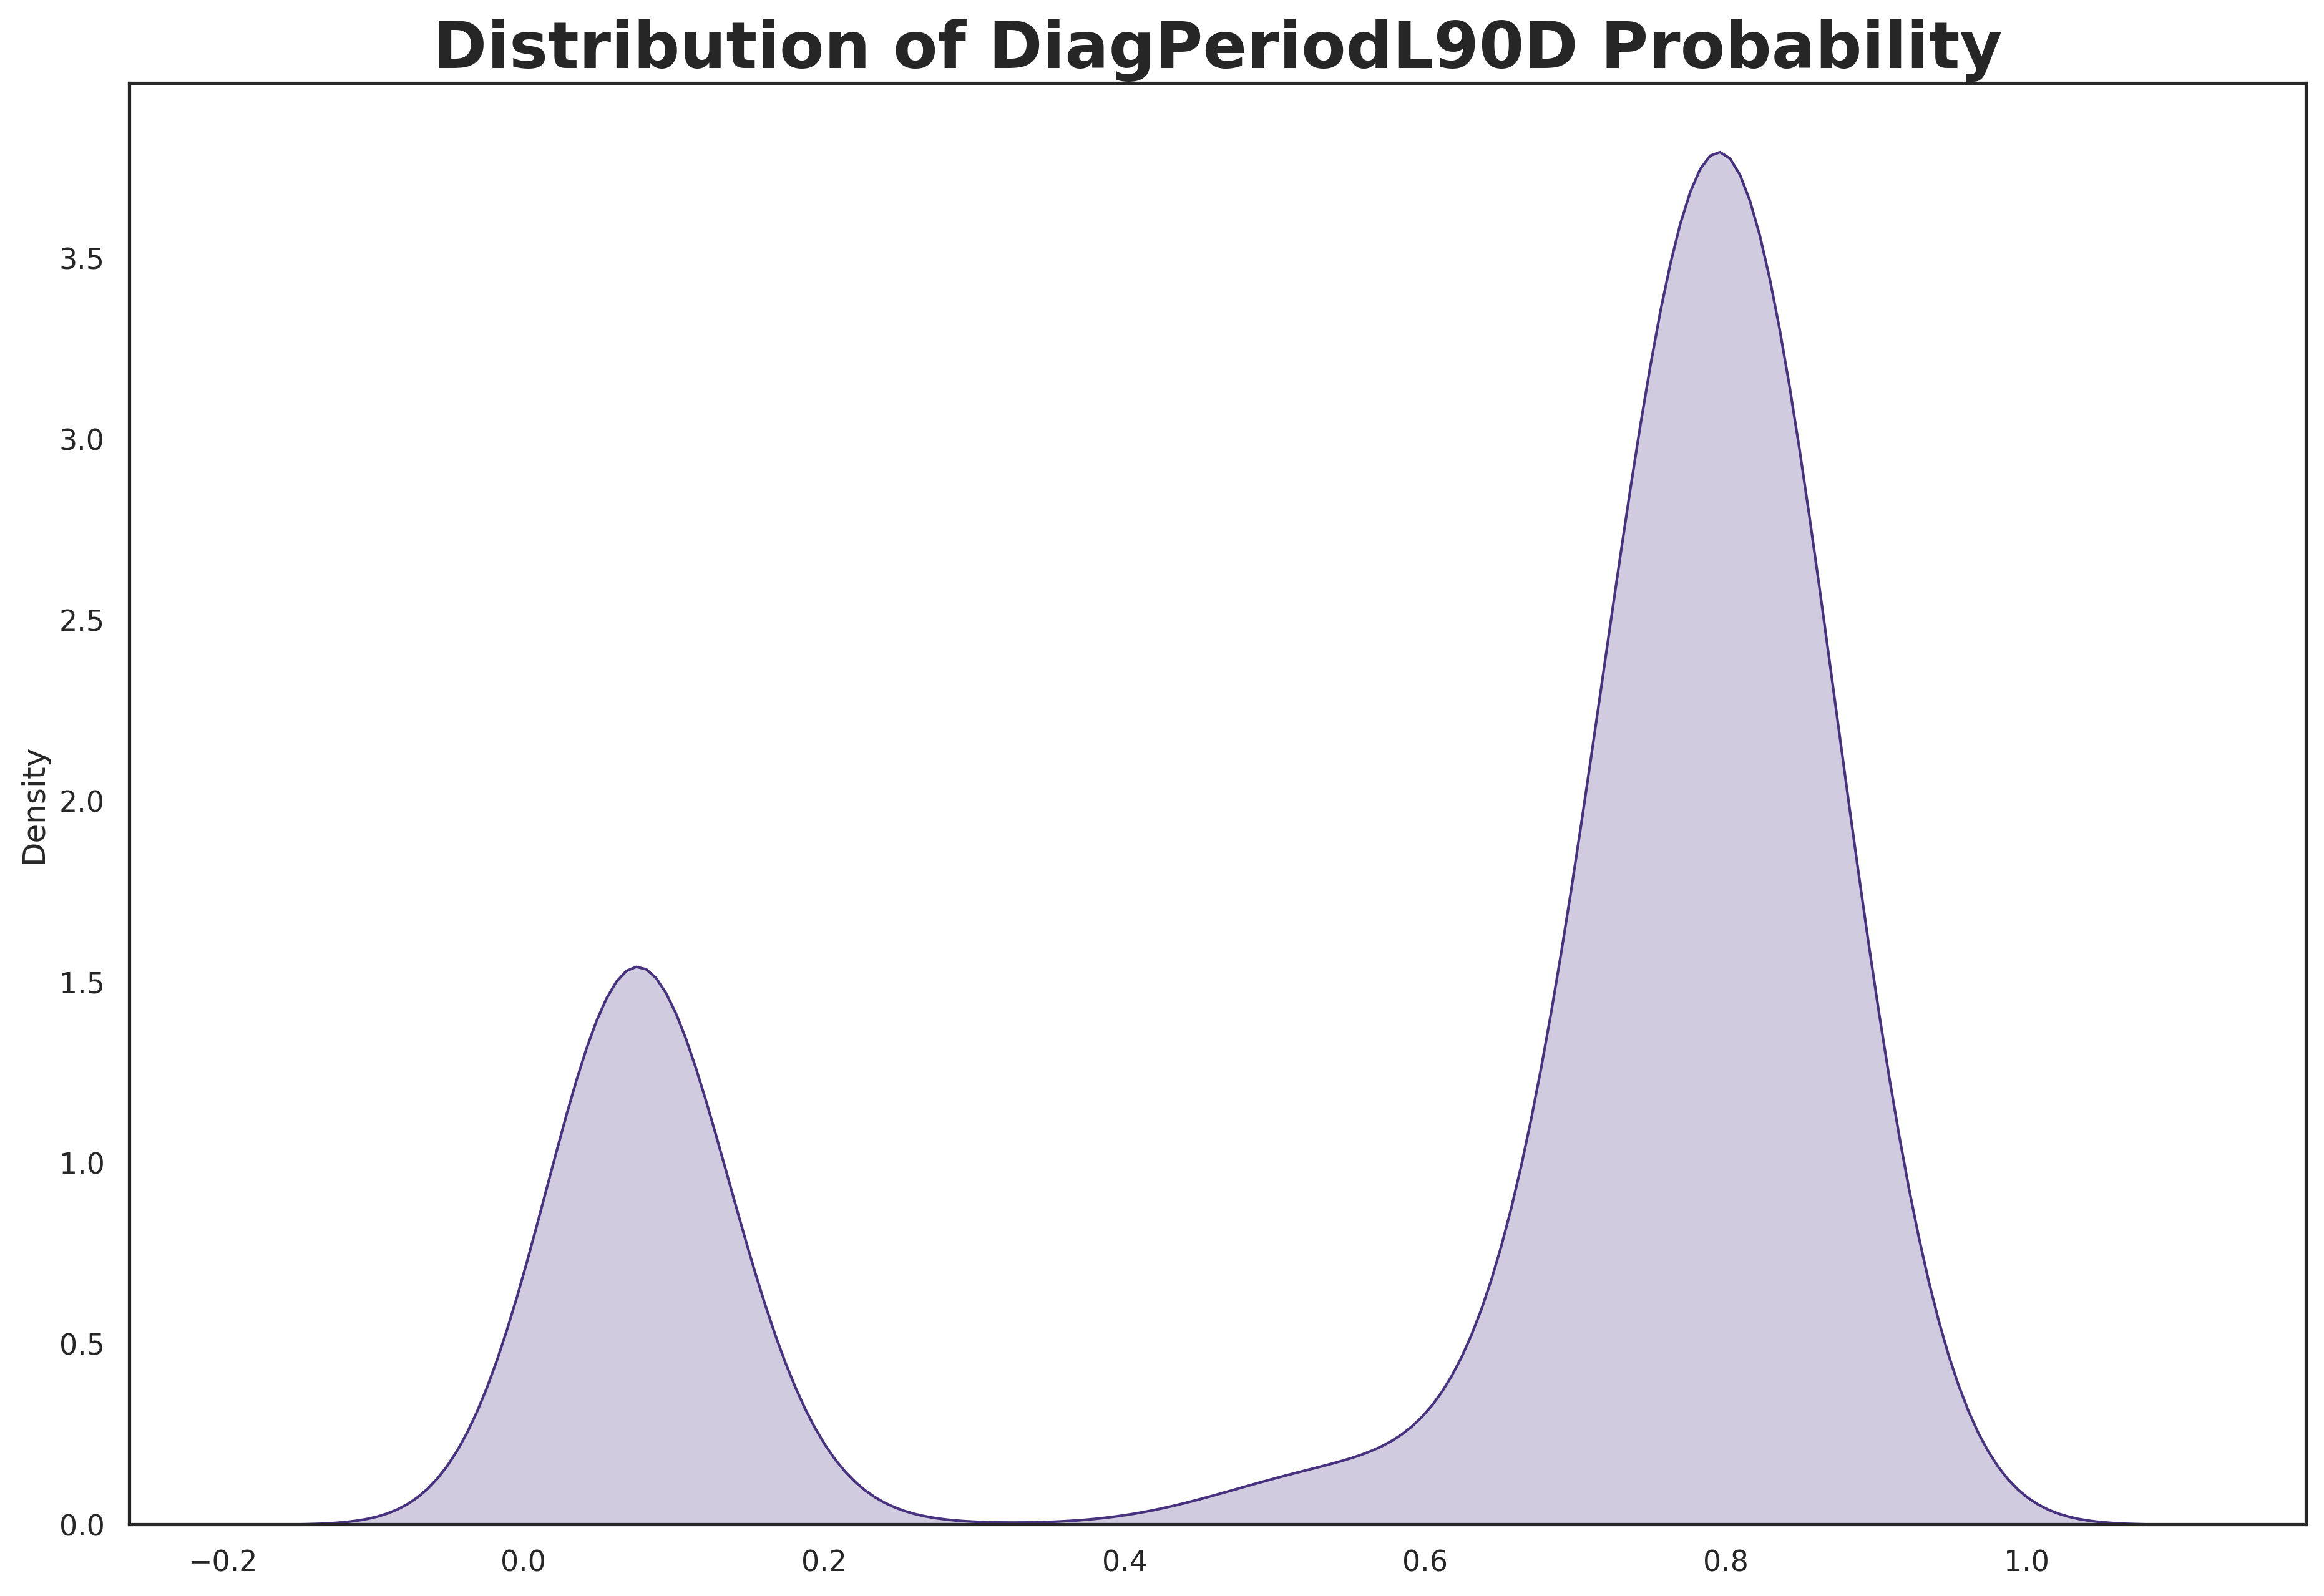

In [84]:
plt.figure(figsize = (15, 10), dpi = 300)
sns.kdeplot(predictions, fill = True)
plt.title("Distribution of DiagPeriodL90D Probability", weight = 'bold', size = 25)
plt.show()

Thanks for reading!